**Table of contents**<a id='toc0_'></a>    
- [Double jet detection (easy mode)](#toc1_)    
- [Nice plots](#toc2_)    
- [Line plots](#toc3_)    
- [By hand clustering and binning](#toc4_)    
- [VS OPP clustering](#toc5_)    
- [VS SOMS](#toc6_)    
- [SOMs composites](#toc7_)    
- [SOMs props](#toc8_)    
- [VS impacts or causes](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from definitions import *
from plots import *
from Experiment import *

import geopandas as gpd
from wavebreaking.processing.events import to_xarray

%load_ext line_profiler
%load_ext autoreload
%autoreload 2
%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


In [2]:
exp_wind = ClusteringExperiment(
    'ERA5', 'Wind', '300', None, None, -60, 60, 25, 85, 
    'anomaly', 'JJA', 'none', None, 
    {'detrended': False, 'time': ('win', 15)}, inner_norm=None
)
da_abs = exp_wind.open_da('anomaly', season='JJA')
X = da_abs.values
exp_wind_rel = ClusteringExperiment(
    'ERA5', 'Wind', '300', None, None, *exp_wind.get_region(), 
    'anomaly', 'JJA', 'doy', {'dayofyear': ('win', 30)}, 
    {'detrended': False, 'time': ('win', 15)}, inner_norm=None
)
da_rel = exp_wind_rel.open_da('anomaly', season='JJA')
exp_wind_low = ClusteringExperiment(
    'ERA5', 'Wind', 'Low', None, 'u', -60, 60, 20, 80, 
    'anomaly', 'JJA', 'doy', {'dayofyear': ('win', 30)}, 
    {'detrended': False, 'time': ('win', 15)}, inner_norm=None
)
da_low = exp_wind_low.open_da('anom', 'JJA')
exp_z = ClusteringExperiment(
    'ERA5', 'Geopotential', '500', None, 'z', -60, 60, 20, 80, 
    'anomaly', 'JJA', 'doy', {'dayofyear': ('win', 30)}, 
    {'detrended': False, 'time': ('win', 15)}, inner_norm=None
)
da_z = exp_z.open_da('anom', 'JJA')
exp_T = ClusteringExperiment(
    'ERA5', 'Temperature', '2m', 'box_-25_60_32_72', 't', 
    None, None, None, None, 'anomaly', 'JJA', 'doy', 
    {'dayofyear': ('win', 30)}, 
    {'detrended': False, 'time': ('fft', 10)}, 
    inner_norm=None
)
da_T = exp_T.open_da('anom', 'JJA')
exp_tp = ClusteringExperiment(
    'ERA5', 'Precipitation', 'surf', 'box_-25_60_32_72', 'tp', 
    None, None, None, None, 'anomaly', 'JJA', 'doy', 
    {'dayofyear': ('win', 30)}, 
    {'detrended': False, 'time': ('fft', 10)}, 
    inner_norm=None
)
da_tp = exp_tp.open_da('anom', 'JJA') * 1000
da_tp = da_tp.drop_duplicates(dim='time').interp(time=da_abs.time)

In [3]:
events = gpd.read_parquet(f'{DATADIR}/ERA5/RWB_index/era5_pv_streamers_350K_1959-2022.parquet')
pv_streamers = to_xarray(da_abs, events[(events.date.dt.year < 2022) & (events.date.dt.month.isin([6, 7, 8])) & (events.date.dt.hour == 0)])
pv_streamers_clim = pv_streamers.mean(dim='time')
pv_streamers_anom = pv_streamers - pv_streamers_clim

# <a id='toc1_'></a>[Double jet detection (easy mode)](#toc0_)

In [7]:
da = da_abs
all_jets = find_all_jets(da)
all_jets, all_props, is_double, is_single = compute_all_jet_props(all_jets)
props_as_np = np.zeros((len(all_jets), 2, len(all_props[0][0])))
for i, props in enumerate(all_props):
    for j, prop in enumerate(props):
        if j > 1:
            continue
        props_as_np[i, j, :] = [val for val in prop.values()] 

In [11]:
all_jets[0]

3

In [39]:
all_jets_over_time = [[j, {0: jet}] for j, jet in enumerate(all_jets[0])]
flags = [[0, 1, 2]]
last_flag = 2
factor = 1
for t, jets in enumerate(all_jets[1:]):
    flags.append([0] * len(jets))
    flagged = []
    for jet_to_try in all_jets_over_time:
        if t not in jet_to_try[1]:
            continue
        for j, jet in enumerate(jets):
            if j in flagged:
                continue
            distances = pairwise_distances(jet_to_try[1][t][:, :2], jet[:, :2])
            if np.sum(np.amin(distances, axis=1)) < factor * len(jet) * len(jet_to_try):
                jet_to_try[1][t + 1] = jet
                flagged.append(j)
                flags[-1][j] = jet_to_try[0]
                continue
        
    for j, jet in enumerate(jets):
        if j not in flagged:
            last_flag += 1
            all_jets_over_time.append([last_flag, {t + 1: jet}]) 
            flags[-1][j] = last_flag
    

# <a id='toc2_'></a>[Nice plots](#toc0_)

In [ ]:
clu = Clusterplot(1, 1, exp_wind_low.get_region())
tsteps = np.random.randint(len(da), size=clu.nrow * clu.ncol)
lon, lat = da.lon.values, da.lat.values
clu.add_contourf([da[t] for t in tsteps], cmap='twilight_shifted', nlevels=8, transparify=3, cbar_label='Wind speed [m/s]')
clu.add_contour([da_z[t] for t in tsteps], colors=['blue', 'none', 'red'], nlevels=3, clabels=True)
color_jets = sns.cubehelix_palette(start=1., rot=1.5, light=.55, dark=.2, hue=2, n_colors=5)
for ax, t in zip(clu.axes, tsteps):
    X = da[t].values
    jets = find_jets_v2(X, lon, lat, eps=0.00028)
    for i, jet in enumerate(jets):
        x, y, s = jet.T
        ax.scatter(x, y, s, color=color_jets[i], alpha=0.3)
        p, r, _, _, _ = np.polyfit(x, y, w=s, deg=4, full=True)
        p = np.poly1d(p)
        label = ''
        ax.plot(x, p(x), color=color_jets[i], label=label, lw=4, alpha=1)
# plt.savefig('Figures/detection_demo.svg')

# Wind animation

In [ ]:
from matplotlib.animation import FuncAnimation
%matplotlib ipympl
exp_wind = ClusteringExperiment(
    'ERA5', 'Wind', '300', None, None, -60, 60, 25, 85, 
    'anomaly', 'JJA', 'none', None, 
    {'detrended': False, 'time': ('win', 15)}, inner_norm=None
)
da = exp_wind.open_da('anomaly', season='JJA')
clu = Clusterplot(1, 1, exp_wind.get_region())
yearidx = 59
tsteps = np.arange(yearidx * 92, (yearidx + 1) * 92 - 1)
titles = da.time[tsteps].dt.strftime("%Y-%m-%d").values
kwargs, cbar_kwargs, im, levelsc = clu.setup_contourf(da[tsteps[:1]], cmap='twilight_shifted', nlevels=8, transparify=3, cbar_label='Wind speed [m/s]')
cs = clu.axes[0].contourf(da.lon.values, da.lat.values, da[tsteps[0]].values, **kwargs)
cbar = clu.fig.colorbar(
    im, ax=clu.fig.axes, spacing="proportional", **cbar_kwargs
)
jets = all_jets[tsteps[0]]
lines = []
for j in range(3):
    try:
        jet = jets[j]
        x, y, s = jet.T
        p = np.polyfit(x, y, w=s, deg=3, full=False)
        p = np.poly1d(p)
        newy = p(x)
    except IndexError:
        x, newy, s = [], [], []
    
    lines.append(clu.axes[0].plot(x, newy, color=COLOR_JETS[j], lw=3)[0])
cbar.ax.set_yticks(levelsc)
def animate(i):
    global cs
    global lines
    for c in cs.collections:
        c.remove()
    cs = clu.axes[0].contourf(da.lon.values, da.lat.values, da[tsteps[i]].values, **kwargs)
    clu.axes[0].set_title(titles[i])
    jets = all_jets[tsteps[i]]
    for j in range(3):
        try:
            jet = jets[j]
            x, y, s = jet.T
            p = np.polyfit(x, y, w=s, deg=3, full=False)
            p = np.poly1d(p)
            newy = p(x)
        except IndexError:
            x, newy, s = [], [], []
        lines[j].set_data(x, newy)
    return cs, lines

ani = FuncAnimation(clu.fig, animate, frames=np.arange(len(tsteps)), blit=True)
ani.save('Figures/anim_with_jets.gif', dpi=300)

# <a id='toc3_'></a>[Line plots](#toc0_)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.flatten()
for i, var in enumerate(all_props[0][0]):
    jet_speeds_1 = np.asarray([props[i][var] for props in all_props for i in range(len(props))])
    jet_speeds_2 = np.asarray([props[0][var] for i, props in enumerate(all_props) if is_single[i]])
    jet_speeds_3 = np.asarray([props[0][var] for i, props in enumerate(all_props) if is_double[i]])
    jet_speeds_4 = np.asarray([props[1][var] for i, props in enumerate(all_props) if is_double[i]])
    axes[i].hist([jet_speeds_2, jet_speeds_3, jet_speeds_1, jet_speeds_4], histtype='step', bins=201, linewidth=2, color=['blue', 'red', 'gray', 'green'], label=['single', 'first in double', 'any', 'second in double'])
    axes[i].set_title(var)
axes[i].legend()

# <a id='toc4_'></a>[By hand clustering and binning](#toc0_)

In [ ]:
mask_1 = np.stack([is_single, is_double], axis=1)
mask1labs = ['single', 'double']


x, y = zip(*[[props[int(double)][key] for key in ['mean_lon', 'mean_lat']] for props, double in zip(all_props, is_double)])
x = np.asarray(x)
y = np.asarray(y)

bins = [-40, -30, -20, -10, 0, 10, 20]
mask2 = np.stack([(x >= bins[i]) & (x < bins[i + 1]) for i in range(len(bins) - 1)], axis=1)
mask2labs = [f'${bins[i]} \leq \lambda<{bins[i + 1]}$' for i in range(len(bins) - 1)]

bins = [20, 30, 40, 50, 60, 70]
mask3 = np.stack([(y >= bins[i]) & (y < bins[i + 1]) for i in range(len(bins) - 1)], axis=1)
mask3labs = [fr'${bins[i]} \leq \theta <{bins[i + 1]}$' for i in range(len(bins) - 1)]

mask = (mask_1[:, :, None, None] & mask2[:, None, :, None] & mask3[:, None, None, :]).reshape(len(mask_1), -1)
masklabs = [f'{lab1}, {lab2}, {lab3}' for lab1 in mask1labs for lab2 in mask2labs for lab3 in mask3labs]
masklabs = np.asarray([f'{masklab}, {np.sum(mask[:, i])}' for i, masklab in enumerate(masklabs)])
maskofmask = np.sum(mask, axis=0) > 10
remainder = ~np.any(mask[:, maskofmask], axis=1)
mask = np.concatenate([mask[:, maskofmask], remainder[:, None]], axis=1)
masklabs = np.append(masklabs[maskofmask], f'none, {np.sum(remainder)}')

In [ ]:
mask.shape

In [ ]:
clu = Clusterplot(8, 4, region=exp_wind.get_region())
clu.add_any_contour_from_mask(da_T, mask, type='contourf', stippling=True)
clu.add_any_contour_from_mask(da, mask, type='contour', clabels=True, titles=masklabs)

# <a id='toc5_'></a>[VS OPP clustering](#toc0_)

In [ ]:
centers, labels = exp_wind_rel.opp_cluster(3, 20, 3, return_type=6)

In [ ]:
mask = labels_to_mask(labels)
n_samples = np.sum(mask, axis=0)
numdjets = np.sum(mask & is_double[:, None], axis=0)
numsjets = np.sum(mask & is_single[:, None], axis=0)
conditional_d = numdjets / np.sum(mask, axis=0)
conditional_s = numsjets / np.sum(mask, axis=0)
signif_dj = np.zeros(len(centers), dtype=bool)
signif_sj = signif_dj.copy()
for i, (ns, ndj, nsj) in enumerate(zip(n_samples, numdjets, numsjets)):
    indices = np.random.rand(100, da_rel.shape[0]).argpartition(ns, axis=1)[:, :ns]
    signif_dj[i] = ndj > np.quantile(np.sum(np.take(is_double, indices), axis=1), q=0.9)
    indices = np.random.rand(100, da_rel.shape[0]).argpartition(ns, axis=1)[:, :ns]
    signif_sj[i] = nsj > np.quantile(np.sum(np.take(is_single, indices), axis=1), q=0.9)
jet_labels = signif_sj + 2 * signif_dj
# titles = [f'Pop: {ns} / {len(da)}, DJ: ${cd * 100:.1f}\%$, SJ: ${cs * 100:.1f}\%$, label:{label}' for ns, cd, cs, label in zip(n_samples, conditional_d, conditional_s, jet_labels)]
unique_labels = np.unique(labels)
pos_or_neg = np.asarray(['pos.', 'neg.'])[(unique_labels > 0).astype(int)]
which_max = np.asarray(['2', '1'])[np.abs(unique_labels).astype(int) % 2]
which_num = ((np.abs(unique_labels) - 1) // 2 + 1).astype(int)
titles = [f'High {pos_or_neg[i]} proj. on T{which_max[i]} maximizer n°{which_num[i]}' for i in range(len(unique_labels))]
midpoint = int(np.ceil(len(titles) // 2))
titles[midpoint] = 'Remainder'
titles = np.asarray([f'{title} , Pop. : {ns} / {len(da)}' for title, ns in zip(titles, n_samples)])

In [ ]:
clu = Clusterplot(4, 3, exp_wind_rel.get_region(), honeycomb=False)
subindex = [4, 2, 0, 5, 3, 1, 7, 9, 11, 8, 10, 12]
clu.add_contourf(centers[subindex], cmap='twilight_shifted', nlevels=6, titles=titles[subindex], transparify=2)
clu.add_any_contour_from_mask(da_z, mask[:, subindex], 'contour', colors=['blue', 'none', 'red'], nlevels=3, transparify=1, clabels=True)
lon, lat = centers.lon.values, centers.lat.values
centers_all_jets = find_all_jets(centers[subindex], height=2, cutoff=300, which=2, eps=0.2)
centers_all_jets, centers_props, centers_double, centers_single = compute_all_jet_props(centers_all_jets, eur_thresh=3)
polyfits = []
for ax, center, jets, dj in zip(clu.axes, centers[subindex], centers_all_jets, centers_double):
    x = center.values
    polyfits.append([])
    for j, jet in enumerate(jets):
        x, y, s = jet.T
        p = np.polyfit(x, y, w=s, deg=3, full=False)
        p = np.poly1d(p)
        polyfits[-1].append(p)
        ax.plot(x, p(x), color=COLOR_JETS[j], lw=3)
plt.savefig('Figures/opp_clu_wind_jets.svg')

In [ ]:
clu = Clusterplot(4, 3, exp_wind_rel.get_region())
clu.add_any_contour_from_mask(
    da_z, mask[:, subindex], 'contour', stippling=False, 
    linestyles=['dashed', 'solid'], 
    colors=['black', 'none', 'black'],
    nlevels=3, clabels=True
)
clu.add_any_contour_from_mask(
    da_T, mask[:, subindex], 'contourf', stippling=True, titles=titles[subindex])
for ax, pfits, jets in zip(clu.axes, polyfits, centers_all_jets):
    for j, (p, jet) in enumerate(zip(pfits, jets)):
        x, y, s = jet.T
        ax.plot(x, p(x), color=COLOR_JETS[j], label=label, lw=4)
plt.savefig('Figures/opp_clu_ts_jets.svg')

In [ ]:
clu = Clusterplot(4, 3, exp_wind_rel.get_region())
clu.add_any_contour_from_mask(
    da_z, mask[:, subindex], 'contour', stippling=False, 
    linestyles=['dashed', 'solid'], 
    colors=['black', 'none', 'black'],
    nlevels=3, clabels=True
)
clu.add_any_contour_from_mask(
    da_tp, mask[:, subindex], 'contourf', stippling=True, titles=titles[subindex], cmap='BrBG')
for ax, pfits, jets in zip(clu.axes, polyfits, centers_all_jets):
    for j, (p, jet) in enumerate(zip(pfits, jets)):
        x, y, s = jet.T
        ax.plot(x, p(x), color=colors_jets[j], label=label, lw=4)
plt.savefig('Figures/opp_clu_tp_jets.svg')

# <a id='toc6_'></a>[VS SOMS](#toc0_)

In [5]:
from simpsom.plots import add_cluster

def timeseries_on_map(timeseries: NDArray, labels: list | NDArray):
    timeseries = np.atleast_2d(timeseries)
    mask = labels_to_mask(labels)
    return np.asarray([[np.mean(timeseries_[mas]) for mas in mask.T] for timeseries_ in timeseries])

In [6]:
net, centers, labels = exp_wind.compute_som(6, 6, 20, return_type=ADJUST_REALSPACE, train_kwargs=dict(train_algo='batch', epochs=1000))

2023-07-16 10:30:57.299 | INFO     | simpsom.network:__init__:116 - Periodic Boundary Conditions active.
2023-07-16 10:30:57.311 | INFO     | simpsom.network:__init__:127 - Hexagonal topology.
2023-07-16 10:30:57.312 | INFO     | simpsom.network:_set_weights:223 - The weights will be loaded from file


In [7]:
n_samples = net.compute_populations()
coords = net.neighborhoods.coordinates
mask = labels_to_mask(labels)
mask_none = mask[:, 0]
mask = mask[:, 1:]
center_none = centers[0]
centers = centers[1:]

In [8]:
numdjets = np.sum(mask & is_double[:, None], axis=0)
numsjets = np.sum(mask & is_single[:, None], axis=0)
conditional_d = numdjets / np.sum(mask, axis=0)
conditional_s = numsjets / np.sum(mask, axis=0)
signif_dj = np.zeros(len(centers), dtype=bool)
signif_sj = signif_dj.copy()

for i, (ns, ndj, nsj) in enumerate(zip(n_samples, numdjets, numsjets)):
    indices = np.random.rand(100, da_rel.shape[0]).argpartition(ns, axis=1)[:, :ns]
    signif_dj[i] = ndj > np.quantile(np.sum(np.take(is_double, indices), axis=1), q=0.9)
    indices = np.random.rand(100, da_rel.shape[0]).argpartition(ns, axis=1)[:, :ns]
    signif_sj[i] = nsj > np.quantile(np.sum(np.take(is_single, indices), axis=1), q=0.9)
meta_labels = 1 + signif_sj + 2 * (signif_dj & ~signif_sj)

In [9]:
centers_all_jets = find_all_jets(centers, height=20, cutoff=1700, which=2)
centers_all_jets, centers_props, centers_double, centers_single = compute_all_jet_props(centers_all_jets, eur_thresh=3)
polyfits = []
for center, jets, dj in zip(centers, centers_all_jets, centers_double):
    polyfits.append([])
    for j, jet in enumerate(jets):
        x, y, s = jet.T
        p = np.polyfit(x, y, w=s, deg=3, full=False)
        p = np.poly1d(p)
        polyfits[-1].append(p)

# <a id='toc7_'></a>[SOMs composites](#toc0_)

In [ ]:
clu = Clusterplot(net.width, net.height, exp_wind.get_region(), honeycomb=True)
titles=[f'DJ: ${cd * 100:.1f}\%$, SJ: ${cs * 100:.1f}\%$' for cd, cs in zip(conditional_d, conditional_s)]
clu.add_contourf(centers, cmap='twilight_shifted', nlevels=7, transparify=3, cbar_label='Wind speed [m/s]')#, titles=titles)
plt.savefig('Figures/som_wind_abs.svg')

In [ ]:
clu = Clusterplot(net.width, net.height, exp_wind.get_region(), honeycomb=True)
titles=[f'DJ: ${cd * 100:.1f}\%$, SJ: ${cs * 100:.1f}\%$' for cd, cs in zip(conditional_d, conditional_s)]
clu.add_contourf(centers, cmap='twilight_shifted', nlevels=7, transparify=3, cbar_label='Wind speed [m/s]')#, titles=titles)
# clu.add_any_contour_from_mask(da_z, mask, 'contour', colors=['blue', 'none', 'red'], nlevels=3, clabels=True)
lon, lat = centers.lon.values, centers.lat.values
clu.cluster_on_fig(coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e'])
plt.savefig('Figures/som_abs_wind_jets.svg')

In [ ]:
clu = Clusterplot(net.width, net.height, exp_wind.get_region(), honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
cbar_kwargs = {
    'label': 'PV streamer occurence anomaly',
    'pad': -0.03,
    'fraction': 0.075    
}
clu.add_any_contour_from_mask(
    pv_streamers_anom, mask, 'contourf', 
    cmap='BrBG', transparify=2,
    cbar_kwargs=cbar_kwargs
)
cbar_kwargs['label'] = 'Surface temperature anomaly [°C]'
cbar_kwargs['pad'] = 0.07
clu.add_any_contour_from_mask(da_T, mask, 'contourf', transparify=2, cbar_kwargs=cbar_kwargs)
clu.add_any_contour_from_mask(
    da_z, mask, 'contour', 
    linestyles=['dashed', 'solid'], 
    colors=['black', 'none', 'black'],
    nlevels=2, clabels=False
)
clu.cluster_on_fig(coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e'])
for ax, pfits, jets in zip(clu.axes, polyfits, centers_all_jets):
    for j, (p, jet) in enumerate(zip(pfits, jets)):
        x, y, s = jet.T
        ax.plot(x, p(x), color=COLOR_JETS[j], lw=4)
plt.savefig('Figures/som_abs_ts_streamers_jets.svg')

In [ ]:
clu = Clusterplot(net.width, net.height, exp_T.get_region(), honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
# clu.add_any_contour_from_mask(
#     da_z, mask, 'contour', 
#     linestyles=['dashed', 'solid'], 
#     colors=['black', 'none', 'black'],
#     nlevels=3, clabels=False
# )
clu.add_any_contour_from_mask(da_T, mask, 'contourf', stippling=True, cbar_label='Temperature anomalies [°C]')
clu.cluster_on_fig(coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e'])
for ax, pfits, jets in zip(clu.axes, polyfits, centers_all_jets):
    for j, (p, jet) in enumerate(zip(pfits, jets)):
        x, y, s = jet.T
        ax.plot(x, p(x), color=COLOR_JETS[j], lw=4)
plt.savefig('Figures/som_abs_ts_jets_zoomed.svg')

In [ ]:
clu = Clusterplot(1, 1, exp_T.get_region(), honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(da_T, mask[:, 35:], 'contourf', stippling=True, cbar_label=None, draw_cbar=False)
ax = clu.axes[0]
pfits, jets = polyfits[35], all_jets[35]
for j, (p, jet) in enumerate(zip(pfits, jets)):
    x, y, s = jet.T
    ax.plot(x, p(x), color=COLOR_JETS[j], lw=4)
clu.fig.set_size_inches(clu.fig.get_size_inches() * 3)
plt.savefig('Figures/som_abs_ts_jets_one_zoomed.svg')

In [ ]:
clu = Clusterplot(net.width, net.height, exp_wind.get_region(), honeycomb=True)
# clu.add_contour(centers, nlevels=4)
clu.add_any_contour_from_mask(pv_streamers_anom, mask, 'contourf', stippling=False, cmap='seismic', cbar_label='PV streamer occurence anomaly')
# clu.add_contour([pv_streamers_clim] * 36, nlevels=2, clabels=True)

clu.cluster_on_fig(coords, labels, cmap=['Grey', '#4bbe58', '#ae279e'])
for ax, pfits, jets in zip(clu.axes, polyfits, centers_all_jets):
    for j, (p, jet) in enumerate(zip(pfits, jets)):
        x, y, s = jet.T
        ax.plot(x, p(x), color=COLOR_JETS[j], lw=4)
plt.savefig('Figures/som_abs_pv_streamer.svg')

In [ ]:
clu = Clusterplot(net.width, net.height, exp_tp.get_region(), honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(da_tp, mask, 'contourf', cmap='BrBG', stippling='red', cbar_label='Precipitation anomaly [mm]')
clu.cluster_on_fig(coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e'])
for ax, pfits, jets in zip(clu.axes, polyfits, centers_all_jets):
    for j, (p, jet) in enumerate(zip(pfits, jets)):
        x, y, s = jet.T
        ax.plot(x, p(x), color=COLOR_JETS[j], lw=4)
plt.savefig('Figures/som_abs_tp_jets_zoomed.svg')

# <a id='toc8_'></a>[SOMs props](#toc0_)

## Proportion of well described days

In [ ]:
X, da = exp_wind.prepare_for_clustering()
X = exp_wind.pca_transform(X, 20)

In [ ]:
proj = project_onto_clusters(X, net.weights)
labels_corr = cluster_from_projs(proj, neg=False)

In [ ]:
unique_labels, counts = np.unique(labels_corr, return_counts=True)
counts = counts 

In [ ]:
net.plot_on_map(
    counts[1:],
    smooth_sigma=0,
    show=False,
    cmap='hot_r',
    cbar_label='Population [days]',
    fonzsize=mpl.rcParams["font.size"],
)

In [ ]:
mask_corr = labels_to_mask(labels_corr)
clu = Clusterplot(1, 1, region=exp_wind.get_region())
_, _ = clu.add_contourf([da[mask_corr[:, 0]].mean(dim='time')], cmap='twilight_shifted', nlevels=6, transparify=3, cbar_label='Wind speed [m/s]')

In [ ]:
clu = Clusterplot(net.height, net.width, honeycomb=True, region=exp_wind.get_region())
_, _ = clu.add_any_contour_from_mask(da, mask_corr[:, 1:], cmap='twilight_shifted', nlevels=7, transparify=3, cbar_label='Wind speed [m/s]')

## trans_mat

In [ ]:
cmap = 'hot_r'
kwargs = {
    "cmap": cmap,
    "norm": Normalize(0, 0.9),
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
for i, ax in enumerate(axes.ravel()):
    further = 2 * i + 1
    trans_mat = net.compute_transmat(step=further)
    kwargs['title'] = f'{further} day(s) further'
    fig, ax = net.plot_on_map(
        np.diag(trans_mat),
        smooth_sigma=0,
        show=False,
        fig=fig, ax=ax,
        draw_cbar=False,
        **kwargs
    )
    fig, ax = add_cluster(
        fig, ax, coords, labels, cmap=['Grey', '#4bbe58', '#ae279e']
    )
im = ScalarMappable(norm=kwargs['norm'], cmap=cmap)
fig.colorbar(im, ax=axes, label='Self transition probability')
plt.savefig('Figures/som_abs_self_transition_multi.svg')

In [ ]:
cmap = 'hot_r'
kwargs = {
    "cmap": cmap,
    "norm": Normalize(0, 1.0),
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
for i, ax in enumerate(axes.ravel()):
    further = 4 * i + 1
    trans_mat = net.compute_transmat(step=further)
    kwargs['title'] = f'{further} day(s) further'
    fig, ax = net.plot_on_map(
        np.sum(trans_mat[labels == 3, :], axis=0),
        smooth_sigma=0,
        show=False,
        fig=fig, ax=ax,
        draw_cbar=False,
        **kwargs
    )
    fig, ax = add_cluster(
        fig, ax, coords, labels, cmap=['Grey', '#4bbe58', '#ae279e']
    )
im = ScalarMappable(norm=kwargs['norm'], cmap=cmap)
fig.colorbar(im, ax=axes, label='Sum transition probabilities from double jets')
plt.savefig('Figures/som_abs_djet_transition_multi.svg')

In [ ]:
cmap = 'hot_r'
kwargs = {
    "cmap": cmap,
    "norm": Normalize(0, 1.0),
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
for i, ax in enumerate(axes.ravel()):
    further = 4 * i + 1
    trans_mat = net.compute_transmat(step=further)
    kwargs['title'] = f'{further} day(s) further'
    fig, ax = net.plot_on_map(
        np.sum(trans_mat[labels == 2, :], axis=0),
        smooth_sigma=0,
        show=False,
        fig=fig, ax=ax,
        draw_cbar=False,
        **kwargs
    )
    fig, ax = add_cluster(
        fig, ax, coords, labels, cmap=['Grey', '#4bbe58', '#ae279e']
    )
im = ScalarMappable(norm=kwargs['norm'], cmap=cmap)
fig.colorbar(im, ax=axes, label='Sum transition probabilities from single jets')
plt.savefig('Figures/som_abs_sjet_transition_multi.svg')

In [ ]:
cmap = 'hot_r'
kwargs = {
    "cmap": cmap,
    "norm": Normalize(0, 1.0),
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
for i, ax in enumerate(axes.ravel()):
    further = 4 * i + 1
    trans_mat = net.compute_transmat(step=further)
    kwargs['title'] = f'{further} day(s) further'
    fig, ax = net.plot_on_map(
        np.sum(trans_mat[labels == 1, :], axis=0),
        smooth_sigma=0,
        show=False,
        fig=fig, ax=ax,
        draw_cbar=False,
        **kwargs
    )
    fig, ax = add_cluster(
        fig, ax, coords, labels, cmap=['Grey', '#4bbe58', '#ae279e']
    )
im = ScalarMappable(norm=kwargs['norm'], cmap=cmap)
fig.colorbar(im, ax=axes, label='Sum transition probabilities from transition region')
plt.savefig('Figures/som_abs_none_transition_multi.svg')

## rt, multi

In [13]:
df = pd.read_csv(f'{DATADIR}/ERA5/daily_nao.csv', delimiter=',')
index = pd.to_datetime(df.iloc[:, :3])
series = xr.DataArray(df.iloc[:, 3].values, coords={'time': index})
nao_summer = series.sel(time=da.time.values)
nao_on_map = timeseries_on_map(nao_summer, net.bmus)[0]

net_mask_da = xr.DataArray(mask, coords={'time': da.time.values, 'cluster': np.arange(net.n_nodes)})
yearly = net_mask_da.resample(time='1Y').sum().values
populations = np.sum(yearly, axis=0)
trends = np.zeros(net.n_nodes)
for i, yearly_ in enumerate(yearly.T):
    trends[i] = np.polyfit(np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0], deg=1)[0]
# trends = np.polynomial.polynomial.polyfit(np.arange(yearly.shape[0]), yearly, deg=1)[1]

In [ ]:

cmap = 'hot_r'
fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    cbar_label='Population [days]',
    fig=fig, ax=axes[0],
    fonzsize=mpl.rcParams["font.size"],
)
axes[0].set_title('Population')
fig, axes[1] = net.plot_on_map(
    trends,
    smooth_sigma=0,
    show=False,
    cmap='bwr',
    cbar_label='Pop. trend [day / year]',
    norm=Normalize(-0.25, 0.25),
    fig=fig, ax=axes[1],
    fonzsize=mpl.rcParams["font.size"],
)
axes[1].set_title('Population trend')
fig, axes[2] = net.plot_on_map(
    nao_on_map,
    smooth_sigma=0,
    show=False,
    fig=fig, ax=axes[2],
    cmap='bwr',
    cbar_label='Mean NAO Index',
    norm=Normalize(-1.0, 1.0),
    fonzsize=mpl.rcParams["font.size"],
)
axes[2].set_title('NAO index')
plt.savefig('Figures/som_abs_multi1.svg')

for ax in axes:
    fig, ax = add_cluster(
        fig, ax, coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e']
    )

In [ ]:
rt_mean, rt_max, rt_trend = net.compute_residence_time(0.0)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
fig, axes[0] = net.plot_on_map(
    rt_mean,
    smooth_sigma=0,
    show=False,
    fig=fig, ax=axes[0],
    cmap=cmap,
    cbar_label='Mean residence time [day]',
    fonzsize=mpl.rcParams["font.size"],
)
axes[0].set_title('Mean res. time')
fig, axes[1] = net.plot_on_map(
    rt_max,
    smooth_sigma=0,
    show=False,
    fig=fig, ax=axes[1],
    cmap=cmap,
    cbar_label='Max. residence time [day]',
    fonzsize=mpl.rcParams["font.size"],
)
axes[1].set_title('Max. res. time')
fig, axes[2] = net.plot_on_map(
    rt_trend,
    smooth_sigma=0,
    show=False,
    fig=fig, ax=axes[2],
    cmap='bwr',
    cbar_label='Res. time trend [day / year]',
    norm=Normalize(-0.18, 0.18),
    fonzsize=mpl.rcParams["font.size"],
)
axes[2].set_title('Res. time trend')
for ax in axes:
    fig, ax = add_cluster(
        fig, ax, coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e']
    )
plt.savefig('Figures/som_abs_multi2.svg')

In [ ]:
rt_mean, rt_max, rt_trend = net.compute_residence_time(1.0)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
fig, axes[0] = net.plot_on_map(
    rt_mean,
    smooth_sigma=0,
    show=False,
    fig=fig, ax=axes[0],
    cmap=cmap,
    cbar_label='Mean residence time [day]',
    fonzsize=mpl.rcParams["font.size"],
)
axes[0].set_title('Mean res. time')
fig, axes[1] = net.plot_on_map(
    rt_max,
    smooth_sigma=0,
    show=False,
    fig=fig, ax=axes[1],
    cmap=cmap,
    cbar_label='Max. residence time [day]',
    fonzsize=mpl.rcParams["font.size"],
)
axes[1].set_title('Max. res. time')
fig, axes[2] = net.plot_on_map(
    rt_trend,
    smooth_sigma=0,
    show=False,
    fig=fig, ax=axes[2],
    cmap='bwr',
    cbar_label='Res. time trend [day / year]',
    norm=Normalize(-0.25, 0.25),
    fonzsize=mpl.rcParams["font.size"],
)
axes[2].set_title('Res. time trend')
for ax in axes:
    fig, ax = add_cluster(
        fig, ax, coords, labels, cmap=['Grey', '#4bbe58', '#ae279e']
    )
plt.savefig('Figures/som_abs_multi2.svg')

## jet indices

In [ ]:
kwargs = {'cmap': 'hot_r'}
fig, axes = plt.subplots(2, 4, figsize=(20, 10 * 0.8))
who = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]
nicer_titles = {
    'mean_lon': 'Averaged longitude',
    'mean_lat': 'Averaged latitude',
    'int_over_europe': 'Integrated speed over Europe',
    'int_all': 'Integrated speed',
}
nicer_numbers = {
    1: 'of the 1st jet',
    2: 'of the 2nd jet'
}
to_plot = timeseries_on_map(np.stack([props_as_np[:, *who_] for who_ in who], axis=0), net.bmus).reshape(2, 4, -1)
ks = list(all_props[0][0])
titles = np.asarray([f'{nicer_titles[ks[j]]} \n {nicer_numbers[i + 1]}' for i, j in who]).reshape(2, 4)
for axs, tpltc, titlec in zip(axes.T, to_plot.transpose(1, 0, 2), titles.T):
    minval, maxval = np.amin(tpltc), np.amax(tpltc)
    kwargs['norm'] = Normalize(minval, maxval)
    im = ScalarMappable(**kwargs)
    for ax, tplt, title in zip(axs, tpltc, titlec):
        fig, ax = net.plot_on_map(
            tplt,
            smooth_sigma=0,
            show=False,
            fig=fig,
            ax=ax,
            draw_cbar=False,
            title=title,
            **kwargs,
        )
        fig, ax = add_cluster(
            fig, ax, coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e']
        )
    fig.colorbar(im, ax=axs)
plt.savefig('Figures/som_abs_jet_props_multi.svg')

## Regional temperature anomalies

In [ ]:
duncan_mask = np.abs(xr.open_dataarray(f'{DATADIR}/ERA5/cluster_def.nc'))
da_T_mod = da_T.interp(lon=duncan_mask.lon.values, lat=duncan_mask.lat.values)
to_plot = np.asarray([[da_T_mod[mas].where(duncan_mask == val).mean().values for mas in mask.T] for val in range(1, 7)])
kwargs = {
    "cmap": 'bwr',
    "norm": Normalize(-2, 2),
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
for region, tplt, ax in zip(REGIONS, to_plot, axes.ravel()):
    fig, ax = net.plot_on_map(
        tplt,
        smooth_sigma=0,
        show=False,
        fig=fig, ax=ax,
        draw_cbar=False,
        **kwargs
    )
    fig, ax = add_cluster(
        fig, ax, coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e']
    )
    ax.set_title(region)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label='Temperature anomaly')
plt.savefig('Figures/som_abs_cluster_temperature_anomaly.svg')

In [ ]:
duncan_mask = np.abs(xr.open_dataarray(f'{DATADIR}/ERA5/cluster_def.nc'))
da_T_mod = da_T.interp(lon=duncan_mask.lon.values, lat=duncan_mask.lat.values)
kwargs = {
    "cmap": 'bwr',
    "norm": Normalize(-2, 2),
}    
for lag in range(10):
    lagged_mask = np.roll(mask, lag, axis=0)
    lagged_mask[:lag, :] = False
    to_plot = np.asarray([[da_T_mod[mas].where(duncan_mask == val).mean().values for mas in lagged_mask.T] for val in range(1, 7)])
    fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
    for region, tplt, ax in zip(REGIONS, to_plot, axes.ravel()):
        fig, ax = net.plot_on_map(
            tplt,
            smooth_sigma=0,
            show=False,
            fig=fig, ax=ax,
            draw_cbar=False,
            **kwargs
        )
        fig, ax = add_cluster(
            fig, ax, coords, labels, cmap=['Grey', '#4bbe58', '#ae279e']
        )
        ax.set_title(region)
    im = ScalarMappable(**kwargs)
    fig.colorbar(im, ax=axes, label='Temperature anomaly')
    fig.suptitle(f'Lag : {lag} day(s)')
    # plt.savefig(f'Figures/som_abs_cluster_temperature_anomaly_{lag=}.svg')

In [ ]:
duncan_mask = np.abs(xr.open_dataarray(f'{DATADIR}/ERA5/cluster_def.nc'))
da_T_mod = da_T.interp(lon=duncan_mask.lon.values, lat=duncan_mask.lat.values)
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
region_index = 2
for lag, ax in enumerate(axes.ravel()):
    lag = 3 * lag
    lagged_mask = np.roll(mask, lag, axis=0)
    lagged_mask[:lag, :] = False
    to_plot = np.asarray([da_T_mod[mas].where(duncan_mask == region_index).mean().values for mas in lagged_mask.T])
    kwargs = {
        "cmap": 'bwr',
        "norm": Normalize(-2, 2),
    }
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig, ax=ax,
        draw_cbar=False,
        **kwargs
    )
    fig, ax = add_cluster(
        fig, ax, coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e']
    )
    ax.set_title(f'Lag : {lag} day(s)')
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label='Temperature anomaly')
plt.savefig(f'Figures/som_abs_{REGIONS[region_index - 1]}_temperature_anomaly_manylags.svg')

In [ ]:
duncan_mask = np.abs(xr.open_dataarray(f'{DATADIR}/ERA5/cluster_def.nc'))
# cmap = make_transparent('viridis', 8)
cmap = 'Accent'
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
norm = BoundaryNorm(np.arange(0.5, 7.5, 1), 6)
im = ax.pcolormesh(duncan_mask.lon.values, duncan_mask.lat.values, duncan_mask.values, shading='nearest', transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax, pad=0.02, location='bottom')
cbar.ax.set_xticks(np.arange(1, 7, 1), REGIONS, rotation=25)
cbar.ax.minorticks_off()

## Dimensionality reduction

In [ ]:
from simpsom import plots as splots
from simpsom.neighborhoods import Neighborhoods
from matplotlib.collections import LineCollection

yearidx = 59
coords = net.neighborhoods.coordinates.copy()
traj = net.bmus[yearidx * 92:(yearidx + 1) * 92]
radius = 0.9 / np.sqrt(3)
nei = Neighborhoods(np, 10, 10, 'hexagons', PBC=False)
othernei = Neighborhoods(np, 6, 6, 'hexagons', PBC=True)
coords = nei.coordinates
othercoords = othernei.coordinates
indices = np.arange(len(coords))
outermask = (
    (indices // nei.height < 2) | 
    (indices // nei.height > nei.height - 3) | 
    (indices % nei.width < 2) | 
    (indices % nei.width > nei.width - 3)
)
grid1 = np.arange(nei.width * nei.height).reshape(nei.height, nei.width, order='F')
grid2  = np.arange(othernei.width * othernei.height).reshape(othernei.height, othernei.width, order='F')
theslice = slice(grid2.shape[0] - 2, grid2.shape[0] - 2 + grid1.shape[0])
grid1[:, :2] = np.tile(grid2[:, -2:].T, 3)[:, theslice].T
grid1[:, -2:] = np.tile(grid2[:, :2].T, 3)[:, theslice].T
grid1[:2, :] = np.tile(grid2[-2:, :], 3)[:, theslice]
grid1[-2:, :] = np.tile(grid2[:2, :], 3)[:, theslice]
grid1 = grid1.flatten(order='F')
grid1[~outermask] = grid2.flatten(order='F')
edgecolors = np.full(len(coords), 'black', dtype=object)
edgecolors[outermask] = 'gray'
alphas = np.ones(len(coords))
alphas[outermask] = 0.2

thistraj = traj[yearidx * 92:(yearidx + 1) * 92 - 1]
populations = np.zeros_like(grid1)
populations[outermask] = 0
thesepops = np.sum(net.bmus[yearidx * 92:(yearidx + 1) * 92, None] == np.arange(net.n_nodes)[None, :], axis=0) 
populations[~outermask] = thesepops

segments = []
reps = []
prev = coords[~outermask][traj[0]]
for i, j in enumerate(traj[1:]):
    ks = np.where(grid1==j)[0]
    distances = np.linalg.norm(prev[None, :] - coords[ks, :], axis=1)
    mindist = np.amin(distances)
    winnerks = ks[np.where(distances == mindist)[0]]
    next_ = coords[~outermask][j].copy()
    if np.all(outermask[winnerks]):
        winnerk = winnerks[0]
        segments.append(np.vstack([prev, coords[winnerk]]))
        ks = np.where(grid1==traj[i])[0]
        distances = np.linalg.norm(next_[None, :] - coords[ks, :], axis=1)
        mindist = np.amin(distances)
        winnerk2 = ks[np.where((distances == mindist) & outermask[ks])[0][0]]
        segments.append(np.vstack([coords[winnerk2], next_]))
        reps.append(2)
    else:
        segments.append(np.vstack([prev, next_]))
        reps.append(1)
    prev = next_.copy()
segments = np.asarray(segments)
jitter = np.random.uniform(-0.1, 0.1, size=(len(traj), 2))
repeats = np.full(len(jitter), 2)
repeats[[0, -1]] = 1
jitter = np.repeat(jitter, repeats, axis=0).reshape(-1, 2, 2)
jitter = np.repeat(jitter, reps, axis=0)
segments = segments + jitter
norm = Normalize(0, len(traj) - 1)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6 * 0.8))
fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)
kwargs = dict(cmap=mpl.colormaps['gray_r'], norm=Normalize(np.amin(thesepops), np.amax(thesepops)))
xlims = [np.amin(coords[~outermask][:, 0]) - 0.8, np.amax(coords[~outermask][:, 0]) + 0.8]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
fig, ax = splots.plot_map(
    coords, populations, 'hexagons', 
    draw_cbar=False, figsize=(15, 13.5), 
    show=False, edgecolors = 'black', cmap='Greys',
    alphas=alphas, linewidths=0, fig=fig, ax=ax
)
cax = fig.add_axes([.65, .019, 0.15, 0.05])
im = ScalarMappable(**kwargs)
fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[0, np.amax(thesepops)])
fig, ax = add_cluster(
    fig, ax, coords[~outermask], meta_labels, cmap=['Grey', '#4bbe58', '#ae279e']
)

lc = LineCollection(segments, cmap='magma', norm=norm)
lc.set_array(np.repeat(np.arange(len(traj) - 1), repeats=reps))
lc.set_linewidth(3)
lc = ax.add_collection(lc)
cbar = fig.colorbar(lc, label=f'Days of summer {YEARSPL[yearidx]}')
list_of_days = np.asarray([0, 14, 30, 44, 61, 75, 91])

pretty_list_of_days = da.time[yearidx * 92 + list_of_days].dt.strftime("%b %d").values
cbar.ax.set_yticks(list_of_days, labels=pretty_list_of_days)
cbar.ax.invert_yaxis()
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# plt.savefig(f'Figures/som_abs_trajectory{YEARSPL[yearidx]}.svg')

## Wind + dimred animation

In [ ]:
from matplotlib.animation import FuncAnimation
%matplotlib inline
exp_wind = ClusteringExperiment(
    'ERA5', 'Wind', '300', None, None, -60, 60, 25, 85, 
    'anomaly', 'JJA', 'none', None, 
    {'detrended': False, 'time': ('win', 15)}, inner_norm=None
)
da = exp_wind.open_da('anomaly', season='JJA')
clu = Clusterplot(1, 1, exp_wind.get_region())
tsteps = np.arange(yearidx * 92, (yearidx + 1) * 92 - 1)
titles = da.time[tsteps].dt.strftime("%Y-%m-%d").values
kwargs_contourf, cbar_kwargs_contourf, im, levelsc = clu.setup_contourf(da[tsteps[:1]], cmap='twilight_shifted', nlevels=8, transparify=3, cbar_label='Wind speed [m/s]')
cs = clu.axes[0].contourf(da.lon.values, da.lat.values, da[tsteps[0]].values, **kwargs_contourf)
cbar = clu.fig.colorbar(
    im, ax=clu.fig.axes, spacing="proportional", **cbar_kwargs_contourf
)


In [ ]:
r1 = len(da.lon) / len(da.lat)
r2 = 1
height = 4
wspace = 0.04
cbar_size = 0.05
fig = plt.figure(figsize=(height * (r1 + r2 + 2 * cbar_size + 3 * wspace), height), dpi=90)
gs = GridSpec(1, 5, width_ratios=(r1, cbar_size, 4 * wspace, r2, cbar_size), wspace=0.02, figure=fig)

fig.add_subplot(gs[2], visible=False)
ax_contourf = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax_contourf.set_extent(
    exp_wind.get_region(),
    crs=ccrs.PlateCarree(),
)
ax_contourf.add_feature(COASTLINE)
cs = ax_contourf.contourf(da.lon.values, da.lat.values, da[tsteps[0]].values, **kwargs_contourf)
cax = fig.add_subplot(gs[1])
fig.colorbar(cs, cax=cax)

ax_trajectory = fig.add_subplot(gs[3])
# ax_trajectory.plot([1, 2])
kwargs_trajectory = dict(cmap=mpl.colormaps['gray_r'], norm=Normalize(np.amin(thesepops), np.amax(thesepops)))
xlims = [np.amin(coords[~outermask][:, 0]) - 0.8, np.amax(coords[~outermask][:, 0]) + 0.8]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
fig, ax_trajectory = splots.plot_map(
    coords, populations, 'hexagons', 
    draw_cbar=False, 
    show=False, edgecolors = 'black', cmap='Greys',
    alphas=alphas, linewidths=0, fig=fig, ax=ax_trajectory
)
cax = fig.add_axes([.67, .81, 0.06, 0.04])
im = ScalarMappable(**kwargs_trajectory)
fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[])
cax.text(-5, 0.35, '0', ha='center', va='center')
max_pop = np.amax(populations)
cax.text(max_pop + 9, 0.35, f'{max_pop}', ha='center', va='center')
fig, ax_trajectory = add_cluster(
    fig, ax_trajectory, coords[~outermask], meta_labels, cmap=['Grey', '#4bbe58', '#ae279e']
)

lc = LineCollection(segments, cmap='magma', norm=norm)
lc.set_array(np.repeat(np.arange(len(traj) - 1), repeats=reps))
lc.set_linewidth(3)
lc = ax_trajectory.add_collection(lc)
cax = fig.add_subplot(gs[4])
cbar = fig.colorbar(lc, label=f'Days of summer {YEARSPL[yearidx]}', cax=cax)
list_of_days = np.asarray([0, 14, 30, 44, 61, 75, 91])

pretty_list_of_days = da.time[yearidx * 92 + list_of_days].dt.strftime("%b %d").values
cbar.ax.set_yticks(list_of_days, labels=pretty_list_of_days)
cbar.ax.invert_yaxis()
ax_trajectory.set_xlim(xlims)
ax_trajectory.set_ylim(ylims)

jets = all_jets[tsteps[0]]
lines = []
for j in range(3):
    try:
        jet = jets[j]
        x, y, s = jet.T
        p = np.polyfit(x, y, w=s, deg=3, full=False)
        p = np.poly1d(p)
        newy = p(x)
    except IndexError:
        x, newy, s = [], [], []
    
    lines.append(ax_contourf.plot(x, newy, color=COLOR_JETS[j], lw=4)[0])


def animate(i):
    global cs
    global lines
    global lc
    for c in cs.collections:
        c.remove()
    cs = ax_contourf.contourf(da.lon.values, da.lat.values, da[tsteps[i]].values, **kwargs_contourf)
    jets = all_jets[tsteps[i]]
    for j in range(3):
        try:
            jet = jets[j]
            x, y, s = jet.T
            p = np.polyfit(x, y, w=s, deg=3, full=False)
            p = np.poly1d(p)
            newy = p(x)
        except IndexError:
            x, newy, s = [], [], []
        lines[j].set_data(x, newy)
    if i > 1:
        to_be_set_visible = np.sum(reps[:i])
        lws = np.zeros(len(segments))
        lws[:to_be_set_visible] = 4
        lc.set_lw(lws)
    else:
        lc.set_lw(0.)
    fig.suptitle(titles[i])
    return cs, lines, lc


ani = FuncAnimation(fig, animate, frames=np.arange(len(tsteps)))
ani.save('Figures/double_anim.gif', dpi=200, fps=5)

In [ ]:
len(reps)

In [ ]:

jets = all_jets[tsteps[0]]
lines = []
for j in range(3):
    try:
        jet = jets[j]
        x, y, s = jet.T
        p = np.polyfit(x, y, w=s, deg=3, full=False)
        p = np.poly1d(p)
        newy = p(x)
    except IndexError:
        x, newy, s = [], [], []
    
    lines.append(clu.axes[0].plot(x, newy, color=COLOR_JETS[j], lw=3)[0])

def animate(i):
    global cs
    global lines
    for c in cs.collections:
        c.remove()
    cs = clu.axes[0].contourf(da.lon.values, da.lat.values, da[tsteps[i]].values, **kwargs)
    clu.axes[0].set_title(titles[i])
    jets = all_jets[tsteps[i]]
    for j in range(3):
        try:
            jet = jets[j]
            x, y, s = jet.T
            p = np.polyfit(x, y, w=s, deg=3, full=False)
            p = np.poly1d(p)
            newy = p(x)
        except IndexError:
            x, newy, s = [], [], []
        lines[j].set_data(x, newy)
    return cs, lines

ani = FuncAnimation(clu.fig, animate, frames=np.arange(len(tsteps)), blit=True)

## SOMs vs hotspells

In [10]:
num_lags = 10
hotspells = get_hostpells_v2(lag_behind=num_lags)[0]
hs_mask = np.zeros((len(da.time), len(REGIONS), num_lags))
hs_mask = xr.DataArray(hs_mask, coords={'time': da.time.values, 'region': REGIONS, 'lag': np.arange(num_lags)})
for i, region in enumerate(REGIONS):
    for hotspell in hotspells[i]:
        try:
            hs_mask.loc[hotspell[:10], region, np.arange(num_lags)] += np.eye(num_lags) * len(hotspell)
        except KeyError:
            ...

In [11]:
len_thresh = 5
conditional_probas = np.sum((hs_mask > len_thresh).values[:, :, :, None] & mask[:, None, None, :], axis=0) / np.sum((hs_mask > len_thresh).values, axis=0)[:, :, None]

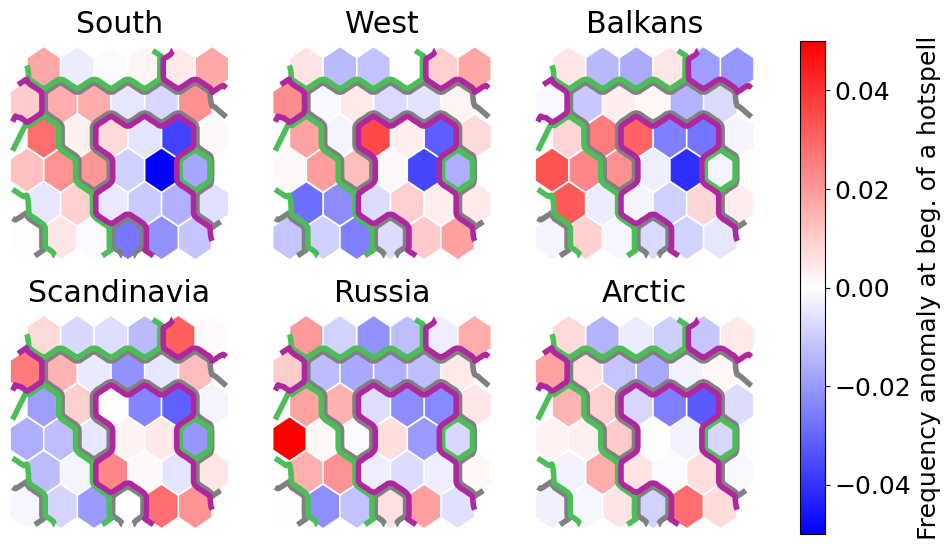

In [14]:
lag_behind = 1
to_plot = conditional_probas[:, -lag_behind, :]
kwargs = {
    "cmap": 'bwr',
    "norm": Normalize(-0.05, 0.05),
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
for region, tplt, ax in zip(REGIONS, to_plot, axes.ravel()):
    fig, ax = net.plot_on_map(
        tplt - populations / np.sum(populations),
        smooth_sigma=0,
        show=False,
        fig=fig, ax=ax,
        draw_cbar=False,
        **kwargs
    )
    fig, ax = add_cluster(
        fig, ax, coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e']
    )
    ax.set_title(region)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label='Frequency anomaly at beg. of a hotspell')
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')

In [15]:
da_bmus = xr.DataArray(labels - 1, coords={'time': da.time.values})

In [16]:
num_lags = 3
hotspells = get_hostpells_v2(lag_behind=num_lags)[0]
clustered_hotspells = {region: [[] for _ in range(net.n_nodes)] for region in REGIONS}
unattributed = {region: [] for region in REGIONS}
for i, region in enumerate(REGIONS):
    for j, hotspell in enumerate(hotspells[i]):
        try:
            unique, counts = np.unique(da_bmus.loc[hotspell[:2 * num_lags]], return_counts=True)
            where = np.argmax(counts)
            if counts[where] >= num_lags / 2:
                clustered_hotspells[region][int(unique[where])].append((len(hotspell), j))
                continue
            raise KeyError
        except KeyError:
            unattributed[region].append((len(hotspell), j))
            

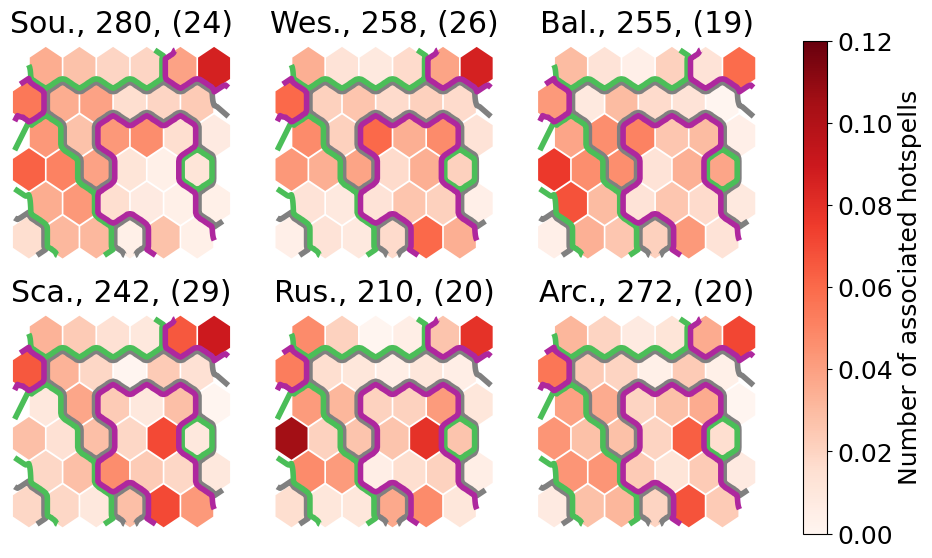

In [17]:
kwargs = {
    "cmap": 'Reds',
    "norm": Normalize(0, 0.12),
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
axes = axes.ravel()
for i, (region, list_of_nodes) in enumerate(clustered_hotspells.items()):
    ax = axes[i]
    tplt = np.asarray([len(l) for l in list_of_nodes])
    fig, ax = net.plot_on_map(
        tplt / (len(hotspells[i]) - len(unattributed[region])),
        smooth_sigma=0,
        show=False,
        fig=fig, ax=ax,
        draw_cbar=False,
        **kwargs
    )
    fig, ax = add_cluster(
        fig, ax, coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e']
    )
    ax.set_title(f'{region[:3]}., {len(hotspells[i])}, ({len(unattributed[region])})')
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label='Number of associated hotspells')
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')

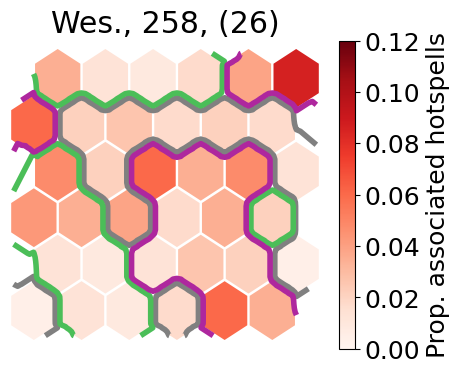

In [19]:
kwargs = {
    "cmap": 'Reds',
    "norm": Normalize(0, 0.12),
}
fig, ax = plt.subplots(figsize=(5, 4))
region = 'West'
i = 1
list_of_nodes = clustered_hotspells[region]
tplt = np.asarray([len(l) for l in list_of_nodes])
fig, ax = net.plot_on_map(
    tplt / (len(hotspells[i]) - len(unattributed[region])),
    smooth_sigma=0,
    show=False,
    fig=fig, ax=ax,
    draw_cbar=False,
    **kwargs
)
fig, ax = add_cluster(
    fig, ax, coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e']
)
ax.set_title(f'{region[:3]}., {len(hotspells[i])}, ({len(unattributed[region])})')
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=ax, label='Prop. associated hotspells')
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')

In [ ]:
kwargs = {
    "cmap": 'bwr',
    "norm": Normalize(-10, 10),
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
axes = axes.ravel()
for i, (region, list_of_nodes) in enumerate(clustered_hotspells.items()):
    ax = axes[i]
    tplt = [np.mean([hs_info[0] for hs_info in l]) for l in list_of_nodes]
    fig, ax = net.plot_on_map(
        tplt - np.nanmean([len(l) for l in hotspells[i]]),
        smooth_sigma=0,
        show=False,
        fig=fig, ax=ax,
        draw_cbar=False,
        **kwargs
    )
    fig, ax = add_cluster(
        fig, ax, coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e']
    )
    ax.set_title(region)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label='Average length anomaly of associated hotspells')
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')